# Example 2: Wavelet analysis

Now that we've learned how to create a `Grid` object and plot the data, we will examine results of the 2D wavelet transform and scalogram of the data.

Let's start again by importing the data into a `Grid` object. This time we will use the `TopoGrid`, which inherits from `Grid` but with more methods.

In [1]:
import numpy as np
import pandas as pd
from plateflex import TopoGrid

# Read header (first line) of data set to get grid parameters
xmin, xmax, ymin, ymax, zmin, zmax, dx, dy, nx, ny = \
pd.read_csv('../data/Topo_NA.xyz', sep='\t', nrows=0).columns[1:].values.astype(float)

# Change type of nx and ny to integers
nx = int(nx); ny = int(ny)

# Read data 
topodata = pd.read_csv('../data/Topo_NA.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

# Load the data as `plateflex` TopoGrid object
topo = TopoGrid(topodata, dx, dy)

The `TopoGrid` class initializes the object with new attributes, in addition to those available from the parent `Grid` class:

In [2]:
topo.__dict__

{'nx': 342,
 'ny': 341,
 'dx': 20.0169157785,
 'dy': 19.9970844654,
 'units': 'm',
 'sg_units': 'm$^2$/|k|',
 'logsg_units': 'log(m$^2$/|k|)',
 'title': 'Topography',
 'ns': 19,
 'k': array([2.60106395e-06, 3.22337138e-06, 3.99456654e-06, 4.95027100e-06,
        6.13462882e-06, 7.60234554e-06, 9.42121512e-06, 1.16752513e-05,
        1.44685680e-05, 1.79301889e-05, 2.22200064e-05, 2.75361676e-05,
        3.41242261e-05, 4.22884849e-05, 5.24060517e-05, 6.49442575e-05,
        8.04822429e-05, 9.97377085e-05, 1.23600066e-04]),
 'data': array([[-4773.43994141, -4770.30712891, -4736.65576172, ...,
         -3779.10644531, -3609.01147461, -4773.43994141],
        [-4778.16992188, -4795.12939453, -4804.34228516, ...,
         -3775.15356445, -3628.46166992, -4778.16992188],
        [-4829.92382812, -4865.66894531, -4797.75439453, ...,
         -3748.75512695, -3561.30175781, -4829.92382812],
        ...,
        [  -45.76174164,   -38.02427292,   -21.88285637, ...,
         -2385.19848633, -24

You see that the `units`, `sg_units` and `logsg_units` have been set to default values, and that a new attribute `water_depth` has been defined. This attribute is required when performing the flexural analysis over water, since the weight of the water column needs to be taken into account. Since the bathymetry can be highly variable, the `TopoGrid` object has a method to smooth it and plot it.

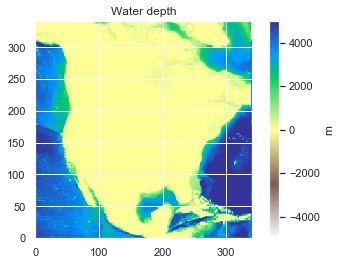

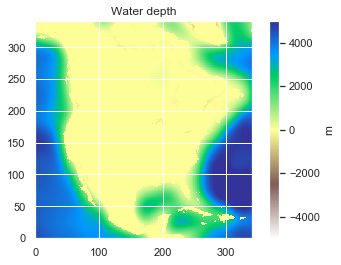

In [3]:
# Unfiltered water depth
topo.plot_water_depth(cmap='terrain_r', vmin=-5000, vmax=5000)

# Now filter and plot
topo.filter_water_depth()
topo.plot_water_depth(cmap='terrain_r', vmin=-5000, vmax=5000)

A couple of things to note: 
* Water depth is defined positive. 
* Once the filter is calculated, the `water_depth` attribute gets updated. To go back to the unfiltered water depth attribute, you can do it manually by setting `topo.water_depth[topo.data<0] = -1.*topo.data[topo.data<0]`

We could further use a mask with contours to beautify the plot

In [4]:
# Create contours
contours = topo.make_contours(0.)

Then make a mask over the land area

In [5]:
# Make mask 
mask = (topo.data > 0.)

And plot water depth:

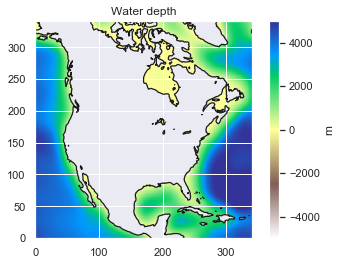

In [6]:
topo.plot_water_depth(mask=mask, contours=contours, cmap='terrain_r', vmin=-5000, vmax=5000)

Now we can calculate the wavelet transform with a simple method call:

<div class="alert alert-block alert-info">
<b>Warning:</b> This step can take some time as the wavelet transform is performed using <i>ns</i> (here <i>ns</i>=19) times <i>na</i>=11 2D FFTs.
</div>

In [7]:
topo.wlet_transform()

The coefficients of the wavelet transform are now available as object attributes

In [8]:
topo.__dict__

{'nx': 342,
 'ny': 341,
 'dx': 20.0169157785,
 'dy': 19.9970844654,
 'units': 'm',
 'sg_units': 'm$^2$/|k|',
 'logsg_units': 'log(m$^2$/|k|)',
 'title': 'Topography',
 'ns': 19,
 'k': array([2.60106395e-06, 3.22337138e-06, 3.99456654e-06, 4.95027100e-06,
        6.13462882e-06, 7.60234554e-06, 9.42121512e-06, 1.16752513e-05,
        1.44685680e-05, 1.79301889e-05, 2.22200064e-05, 2.75361676e-05,
        3.41242261e-05, 4.22884849e-05, 5.24060517e-05, 6.49442575e-05,
        8.04822429e-05, 9.97377085e-05, 1.23600066e-04]),
 'data': array([[-4773.43994141, -4770.30712891, -4736.65576172, ...,
         -3779.10644531, -3609.01147461, -4773.43994141],
        [-4778.16992188, -4795.12939453, -4804.34228516, ...,
         -3775.15356445, -3628.46166992, -4778.16992188],
        [-4829.92382812, -4865.66894531, -4797.75439453, ...,
         -3748.75512695, -3561.30175781, -4829.92382812],
        ...,
        [  -45.76174164,   -38.02427292,   -21.88285637, ...,
         -2385.19848633, -24

The wavelet coefficients have a shape of (`nx`, `ny`, `na`=11, `ns`), where `na` is the number of azimuths over which the Morlet wavelet is defined (11 is hard coded to obtain an isotropic fan wavelet), and `ns` is the number of wavenumbers calculated during initialization of the `Grid` object.

In [9]:
topo.wl_trans.shape

(342, 341, 11, 19)

You can now plot the transform at single azimuth and wavenumber indices. Note that default plotting arguments can be changed, as before.

<div class="alert alert-block alert-info">
<b>Note:</b> If you try to plot the coefficients of the wavelet transform before calculating it, the plot_transform() method will first call the wlet_transform() method and store the coefficients as attributes.
</div>

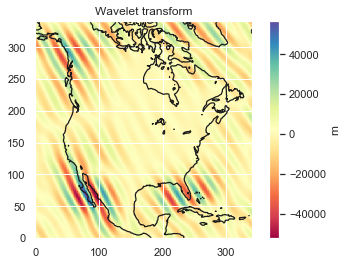

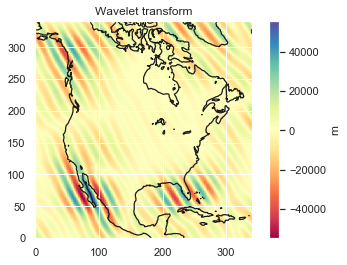

In [31]:
topo.plot_transform(kindex=7, aindex=9, contours=contours, cmap='Spectral')

Note that the wavelet transform returns a complex array, and the real and imaginary parts are plotted separately.

To calculate the wavelet scalogram, you could type `topo.wlet_scalogram()`, but instead we will try to plot it directly, which, as for the `plot_transform()` method, will calculate it first anyway!

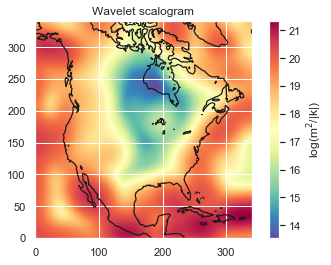

In [32]:
topo.plot_scalogram(kindex=7, contours=contours, cmap='Spectral_r', log=True)

Here we plotted the log value of the scalogram, since it is equivalent to the power-spectra density but for the wavelet transform. 

<div class="alert alert-block alert-warning">
<b>Warning:</b> You will notice some edge effects at the borders of the grid (mostly at the South and West edges, due to mirroring along the North and East edges), particularly at higher wavenumbers (shorter wavelengths). These are due to Gibbs effects near the sharp edges of the grid, since we use the FFT to calculate the wavelet transform. Having a grid larger than your region of interest is always a good idea.
</div>

Now go to Example 3 to examine the wavelet admittance and coherence between two grids.